# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [3]:
### helper functions ###

def readAnchor(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    anchor_ind = []

    for line in A:
        if "FIX" in line:
            fix,ind = line.split()
            anchor_ind.append(int(ind))

    return np.array(anchor_ind)

def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return np.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))

    return (np.array( ind1_arr), np.array(ind2_arr), np.array(del_x), np.array(del_y), np.array(del_theta))

def draw(X, Y, THETA,c1='ro',c2='g->'):
    ax = plt.subplot(111)
    ax.plot(X, Y, c1)
    ax.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        ax.plot([X[i], x2], [Y[i], y2], c2)

In [4]:
def get_pose_graph(fileName):
    
    ind1,ind2,del_x,del_y,del_theta = readEdge(fileName)

    sz = max(np.max(ind1),np.max(ind2)) + 1 

    x = np.zeros((sz,1))
    y = np.zeros((sz,1))
    theta = np.zeros((sz,1))

    done = [False]*sz

    x0,y0,theta0 = readVertex(fileName)

    sz = x0.shape[0]
    
    x[:sz] = x0.reshape((sz,1))
    y[:sz] = y0.reshape((sz,1))
    theta[:sz] = theta0.reshape((sz,1))

    done[:sz] = [True]*sz
    
    for k in range(ind1.shape[0]):
        i = ind1[k]
        j = ind2[k]
        if done[j] is True:
            continue
            
        x[j] = x[i] + del_x[k]*math.cos(theta[i]) - del_y[k]*math.sin(theta[i])
        y[j] = y[i] + del_y[k]*math.cos(theta[i]) + del_x[k]*math.sin(theta[i])
        theta[j] = theta[i] + del_theta[k]
        done[j] = True 
    
    return ind1,ind2,del_x,del_y,del_theta,x,y,theta

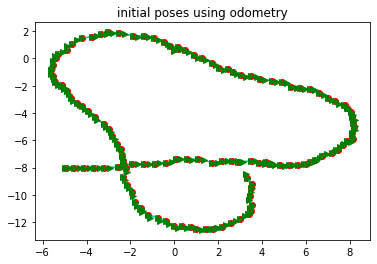

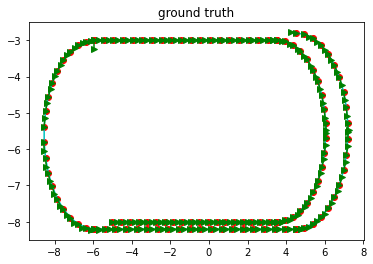

In [5]:
ind1,ind2,del_x,del_y,del_theta,x_initial,y_initial,theta_initial = get_pose_graph("../data/edges.txt")

_,_,_,_,_,x_gt,y_gt,theta_gt = get_pose_graph("../data/gt.txt")

plt.title("initial poses using odometry")
draw(x_initial,y_initial,theta_initial,'ro','g->')
plt.show()
plt.title("ground truth")
draw(x_gt,y_gt,theta_gt,'ro','g->')
plt.show()

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

In [27]:
def build_linear_sys(x,info_mat,num_edges,num_vertices,ind1,ind2,del_x,del_y,anchor_ind,x_anchor):
    
    ### residual ###
    r = np.zeros((3*num_edges,1))

    for k in range(num_edges-len(anchor_ind)):      
        i = ind1[k]
        j = ind2[k]
        r[3*k] = x[3*i] + del_x[k]*math.cos(x[3*i+2]) - del_y[k]*math.sin(x[3*i+2]) - x[3*j]
        r[3*k+1] = x[3*i+1] + del_y[k]*math.cos(x[3*i+2]) + del_x[k]*math.sin(x[3*i+2]) - x[3*j+1]
        r[3*k+2] = x[3*i+2] + del_theta[k] - x[3*j+2]
    
    ### anchor constraint ###
    k = num_edges-len(anchor_ind)
    for i in anchor_ind:
        r[3*k] = x[3*i] - x_anchor[3*i]
        r[3*k+1] = x[3*i+1] - x_anchor[3*i+1]
        r[3*k+2] = x[3*i+2] - x_anchor[3*i+2]
    
    ### compute cost from residual ###
    cost = float(np.matmul(r.T,np.matmul(info_mat,r))/2)
      
    ### Jacobian ###
    J = np.zeros((3*num_edges,3*num_vertices),dtype=np.float64) 

    I_3x3 = np.eye(3,3)

    for k in range(num_edges-1):
        i = ind1[k]
        j = ind2[k]
        J[3*k:3*k+3,3*i:3*i+3] = I_3x3
        J[3*k,3*i+2] = - del_x[k]*math.sin(x[3*i+2]) - del_y[k]*math.cos(x[3*i+2])
        J[3*k+1,3*i+2] = - del_y[k]*math.sin(x[3*i+2]) + del_x[k]*math.cos(x[3*i+2])
        J[3*k:3*k+3,3*j:3*j+3] = -1*I_3x3
    ### anchor ###
    J[-3:,:3] = I_3x3
    
    ### find H,b ###
    b = np.matmul(np.matmul(J.T,info_mat),r)
    H = np.matmul(np.matmul(J.T,info_mat),J)
    
#     print(J)
#     plt.imshow(H)
#     plt.show()
#     plt.imshow(b)
#     plt.show()
    
    return H,b,cost

In [7]:
### load data ###

ind1,ind2,del_x,del_y,del_theta,x_initial,y_initial,theta_initial = get_pose_graph("../data/edges.txt")
anchor_ind = readAnchor("../data/edges.txt")

_,_,_,_,_,x_gt,y_gt,theta_gt = get_pose_graph("../data/gt.txt")

num_vertices = x_initial.shape[0]
num_edges = ind1.shape[0] + len(anchor_ind)

### store all the pose values x,y,z in a single vector of size (3*n,1)
x_noisy = np.zeros((3*num_vertices,1))
x_noisy[0::3] = x_initial
x_noisy[1::3] = y_initial
x_noisy[2::3] = theta_initial
x_anchor = np.zeros((3*len(anchor_ind),1))
x_anchor[0::3] = x_initial[anchor_ind]
x_anchor[1::3] = y_initial[anchor_ind]
x_anchor[2::3] = theta_initial[anchor_ind]

In [20]:
### information matrix ###
info_mat = np.zeros((3*num_edges,3*num_edges))
anch = float(1000)
odom = float(500)
lc = float(700)

for k in range(num_edges):
    ### if anchor ###
    if k >= num_edges - len(anchor_ind):
        info_mat[3*k,3*k] = anch
        info_mat[3*k+1,3*k+1] = anch
        info_mat[3*k+2,3*k+2] = anch
    
    ### if consecutive nodes ###
    elif ind2[k] == ind1[k]+1:
        info_mat[3*k,3*k] = odom
        info_mat[3*k+1,3*k+1] = odom
        info_mat[3*k+2,3*k+2] = odom

    ### if loop closure ###
    else:
        info_mat[3*k,3*k] = lc
        info_mat[3*k+1,3*k+1] = lc
        info_mat[3*k+2,3*k+2] = lc

### Jacobian using jax

In [ ]:
def simpleJ(x):
    global del_x,del_y,del_theta,num_edges,ind1,ind2
    r = np.zeros((3*num_edges,1))

    for k in range(num_edges-1):    
        i = ind1[k]
        j = ind2[k]
        r[3*k] = x[3*i][0].val + del_x[k]*math.cos(x[3*i+2][0].val) - del_y[k]*math.sin(x[3*i+2][0].val) - x[3*j][0].val
        r[3*k+1] = x[3*i+1][0].val + del_y[k]*math.cos(x[3*i+2][0].val) + del_x[k]*math.sin(x[3*i+2][0].val) - x[3*j+1][0].val
        r[3*k+2] =x[3*i+2][0].val + del_theta[k] - x[3*j+2][0].val
   
    ### anchor constraint ###
    r[-3] = x[0][0].val - 0 
    r[-2] = x[1][0].val - 0 
    r[-1] = x[2][0].val - 0 
    
    return r

f = lambda a: simpleJ(a) # Now f is just a function of variable to be differentiated

num_vertices = x_initial.shape[0]
num_edges = ind1.shape[0] + 1 

J = jacfwd(f)


In [23]:
def build_linear_sys(x,info_mat,num_edges,num_vertices,ind1,ind2,del_x,del_y,x0,y0,theta0,J):
    ### residual ###
    r = np.zeros((3*num_edges,1))

    for k in range(num_edges-1):    
        i = ind1[k]
        j = ind2[k]
        r[3*k] = x[3*i] + del_x[k]*math.cos(x[3*i+2]) - del_y[k]*math.sin(x[3*i+2]) - x[3*j]
        r[3*k+1] = x[3*i+1] + del_y[k]*math.cos(x[3*i+2]) + del_x[k]*math.sin(x[3*i+2]) - x[3*j+1]
        r[3*k+2] = x[3*i+2] + del_theta[k] - x[3*j+2]
    ### anchor constraint ###
    r[-3] = x[0] - x0 
    r[-2] = x[1] - y0
    r[-1] = x[2] - theta0
    #    
    ### compute cost from residual ###
#     Jac = J(x).reshape(420,360)

#     print(Jac.shape, info_mat.shape)
    cost = int(np.matmul(r.T,np.matmul(info_mat,r))/2)
    
    ### Jacob using Jax ###
    
    
    ### Jacobian ###
    J = np.zeros((3*num_edges,3*num_vertices)) 

    I_3x3 = np.eye(3,3)

    for k in range(num_edges-1):
        i = ind1[k]
        j = ind2[k]
        J[3*k:3*k+3,3*i:3*i+3] = I_3x3
        J[3*k,3*i+2] = - del_x[k]*math.sin(x[3*i+2]) - del_y[k]*math.cos(x[3*i+2])
        J[3*k+1,3*i+2] = - del_y[k]*math.sin(x[3*i+2]) + del_x[k]*math.cos(x[3*i+2])
        J[3*k:3*k+3,3*j:3*j+3] = -1*I_3x3
    ### anchor ###
    Ja[-3:,:3] = I_3x3
    
    
    ### find H,b ###
    b = np.matmul(np.matmul(Jac.T,info_mat),r)
    H = np.matmul(np.matmul(Jac.T,info_mat),Jac)
    
  
    
    return H,b,cost

### Optimization using Jacobian created manually

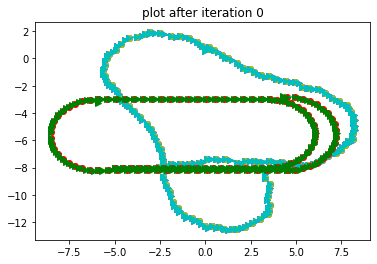

cost after iteration 0 : 639371.6381937417
cost after iteration 1 : 90906.25968976355
cost after iteration 2 : 17838.657449656777
cost after iteration 3 : 2335.094594536102
cost after iteration 4 : 11604.610688534387
cost after iteration 5 : 11604.610688534387
cost after iteration 6 : 684.9213108044274
cost after iteration 7 : 1377.19050786309
cost after iteration 8 : 1377.19050786309
cost after iteration 9 : 475.01458844114944


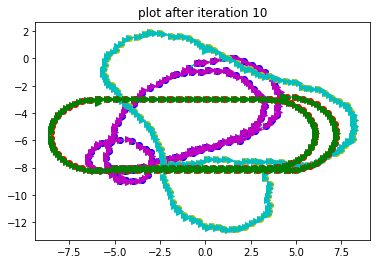

cost after iteration 10 : 466.1670535029581
cost after iteration 11 : 449.00219074291385
cost after iteration 12 : 446.2995271798111
cost after iteration 13 : 445.2197993070136
cost after iteration 14 : 444.8344712804655
cost after iteration 15 : 444.68158625904914
cost after iteration 16 : 444.6198302793868
cost after iteration 17 : 444.59442797383275
cost after iteration 18 : 444.5838933670406
cost after iteration 19 : 444.57950215822046


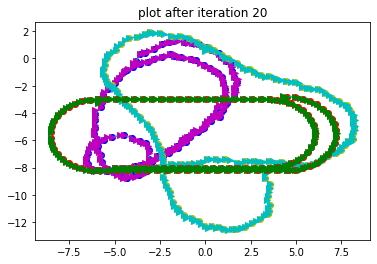

cost after iteration 20 : 444.57766637919246
cost after iteration 21 : 444.57689755501565
cost after iteration 22 : 444.57657522514234
cost after iteration 23 : 444.576439999156
cost after iteration 24 : 444.5763832451836
cost after iteration 25 : 444.5763594197064
cost after iteration 26 : 444.5763494161378
cost after iteration 27 : 444.5763452155435
cost after iteration 28 : 444.57634345156595
cost after iteration 29 : 444.57634271078115


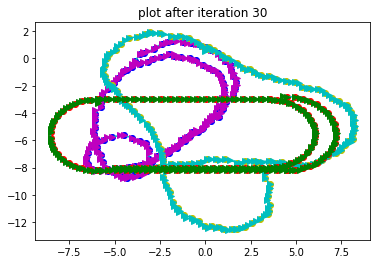

cost after iteration 30 : 444.5763423996799
cost after iteration 31 : 444.5763422690274
cost after iteration 32 : 444.57634221415697
cost after iteration 33 : 444.576342191113
cost after iteration 34 : 444.576342181435
cost after iteration 35 : 444.5763421773703
cost after iteration 36 : 444.57634217566334
cost after iteration 37 : 444.57634217494655
cost after iteration 38 : 444.57634217464533
cost after iteration 39 : 444.5763421745186


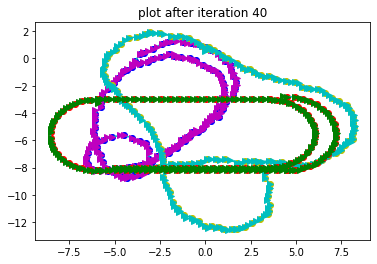

cost after iteration 40 : 444.57634217446576
cost after iteration 41 : 444.57634217444337
cost after iteration 42 : 444.5763421744339
cost after iteration 43 : 444.57634217443024
cost after iteration 44 : 444.57634217442836
cost after iteration 45 : 444.5763421744278
cost after iteration 46 : 444.5763421744274
cost after iteration 47 : 444.57634217442745
cost after iteration 48 : 444.57634217442745
cost after iteration 49 : 444.5763421744272


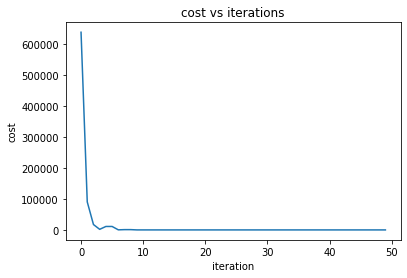

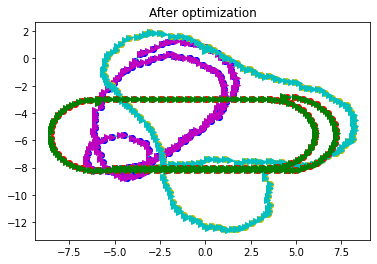

In [28]:
### optimization ###
x = x_noisy

num_iter = 50
Lambda = 0.01

cost = []
cost_gt = []
I = np.eye(3*num_vertices,3*num_vertices)
i = 0

for i in range(num_iter):
   
    if i%10 == 0:
        draw(x[0::3],x[1::3],x[2::3],'bo','m->')
        draw(x_noisy[0::3],x_noisy[1::3],x_noisy[2::3],'yo','c->')
        draw(x_gt,y_gt,theta_gt)
        plt.title(f"plot after iteration {i}")
        plt.show()
    
    x_prev = x

    H,b,temp_cost = build_linear_sys(x,info_mat,num_edges,num_vertices,ind1,ind2,del_x,del_y,anchor_ind,x_anchor)

    print(f"cost after iteration {i} : {temp_cost}")
    
    cost.append(temp_cost)
    
    dx = -np.matmul(np.linalg.inv(H + Lambda*I),b)

    x = x + dx
    
    if i == 0:
        continue

    if cost[i] > cost[i-1]:
        x = x_prev
        Lambda = Lambda*2
    else:
        Lambda = Lambda/2

plt.plot(cost)
plt.title("cost vs iterations")
plt.ylabel("cost")
plt.xlabel("iteration")
plt.show()

### plot after optimization ###
draw(x[0::3],x[1::3],x[2::3],'bo','m->')
draw(x_noisy[0::3],x_noisy[1::3],x_noisy[2::3],'yo','c->')
draw(x_gt,y_gt,theta_gt)
plt.title("After optimization")
plt.show()

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

### Solution

We considered each pose to be formed of three variables, ie, pose[i] = $[ x[i],y[i],\theta[i] ]$ 

So , the optimization variable will become $ X= [x[0] , y[0] , \theta[0] , x[1] , y[1] , \theta[1] .... , x[n] , y[n] , \theta[n]]^T $

We have to find an X which gives optimum value for the following residual 

$ 
r[3.k] = x[3.i] + del_x[k].cos(x[3.i+2]) - del_y[k].sin(x[3.i+2]) - x[3.j] \\
r[3.k+1] = x[3.i+1] + del_y[k].cos(x[3.i+2]) + del_x[k].sin(x[3.i+2]) - x[3.j+1] \\
r[3.k+2] = x[3.i+2] + del_theta[k] - x[3.j+2]    
$

#### The size of residual will be 3n x 1 vector where n is the number of nodes

The index 3k corresponds to the x component of the error of the $k^{th}$ edge . Similarly , 3k+1 corresponds to error in y and 3k+2 corresponds to error in $\theta$

Once we write the optimization variable and residual as above, the optimization problem becomes similar to the 1D slam case. 

We define number of edges as follows 

number of edges = loop constraints + consecutive nodes constraints + anchors


Generally Jacobian would be (number of edges) X (number of vertices) , but here each edge corresponds to three variable and each vertex corresponds to three variable , thus making  $\frac{\partial d e_{ij}}{\partial X_i}$  a 3x3 matrix instead of a scalar. If we do this directly, each element of the Jacobiuan would be a 3x3 matrix but instead using the notation defined previously, we can unfold the pose vector and append all vectors to get a large vector of dimension 3n x 1 giving a Jacobian of dimension 3n X 3m and perform LM optimization directly ont this.

#### H Matrix using imshow()

<img src="../results/H_matrix.png" />


#### Observation regarding Optimization process

Initially, the loop closure works properly and we can see improvement in the mapping and convergence towards the ground truth but eventually the trajectory diverges a bit from ground truth but ends up with two loops as expected in the ground truth.

<img src="../results/trajectory_predict.png" />



## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [40]:
def writeAnchor(fileName,anchor_ind):
    f = open(fileName,'a')
    
    for i in anchor_ind:
        f.write("FIX "+str(i)+"\n")
    
    f.close()
    
def writeEdge(fileName,num_edges,ind1,ind2,del_x,del_y,del_theta,odom,lc,gt=False):
    f = open(fileName,'a')
    
    val = 10
    for i in range(num_edges):
        s = "EDGE_SE2 "+str(ind1[i])+" "+str(ind2[i])+" "
        s = s + str(del_x[i])+" "+str(del_y[i])+" "+str(del_theta[i])+" "
        if ind2[i] == ind1[i]+1:
            val = odom
        else:
            if gt == False:
                val = lc
        s = s + str(val)+" 0.0 0.0 "+str(val)+" 0.0 "+str(val)+"\n"
        f.write(s)
    
    f.close()
    
def writeVertex(fileName,num_vertices,x,y,theta):
    f = open(fileName,'a')
    
    for i in range(num_vertices):
        f.write("VERTEX_SE2 "+str(i)+" "+str(x[i,0])+" "+str(y[i,0])+" "+str(theta[i,0])+"\n")
    
    f.close()

In [41]:
### writing final trajectory as a g2o file ###
writeVertex("../results/opt.g2o",num_vertices,x[0::3],x[1::3],x[2::3])
writeEdge("../results/opt.g2o",ind1.shape[0],ind1,ind2,del_x,del_y,del_theta,odom,lc)
writeAnchor("../results/opt.g2o",anchor_ind)
### writing ground truth as a g2o file ###
writeVertex("../results/gt.g2o",num_vertices,x_gt,y_gt,theta_gt)
writeEdge("../results/gt.g2o",num_vertices-1,ind1,ind2,del_x,del_y,del_theta,500,500,True)
writeAnchor("../results/gt.g2o",anchor_ind)